# Challenge
O problema consiste em montar um modelo de machine learning que preveja qual nota um filme receberia caso fosse colocado no catálogo.  
Não se preocupe muito com a precisão final do modelo.  
Os ítens que serão avaliados individualmente são os seguintes:

- Tratamento dos dados.
- Feature engeneering.
- Divisão da base de dados entre dataset teste e dataset treino.
- A Matriz de Confusão do seu modelo de testes assim como o gráfico de precision e recall do seu modelo
- Tendo em vista o resultado final o que você faria para melhorar o modelo?

In [328]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data processing

In [329]:
# Target = 'rating'
df = pd.read_excel('dataset_netflix.xlsx', engine='openpyxl')

In [330]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6234 entries, 0 to 6233
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   show_id       6234 non-null   int64         
 1   type          6234 non-null   object        
 2   title         6234 non-null   object        
 3   director      4264 non-null   object        
 4   cast          6233 non-null   object        
 5   country       6233 non-null   object        
 6   date_added    6222 non-null   datetime64[ns]
 7   release_year  6233 non-null   float64       
 8   rating        6233 non-null   float64       
 9   duration      6233 non-null   object        
 10  listed_in     6233 non-null   object        
 11  description   6233 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(8)
memory usage: 584.6+ KB


In [331]:
df['director'] = df.director.fillna(value='Unknow')

In [332]:
df['type'] = df.type.astype('category')
df['director'] = df.director.str.split(',')
df['cast'] = df.cast.str.split(',')
df['country'] = df.country.str.split(',')
df['duration'] = df.duration.str.split(' ')
df['listed_in'] = df.listed_in.str.split(',')
df2['date_added_month'] = df2.date_added.dt.month
df2['date_added_year'] = df2.date_added.dt.year

In [333]:
df.dropna(inplace=True)

In [334]:
df.isnull().values.any()

False

In [335]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6222 entries, 0 to 6222
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   show_id       6222 non-null   int64         
 1   type          6222 non-null   category      
 2   title         6222 non-null   object        
 3   director      6222 non-null   object        
 4   cast          6222 non-null   object        
 5   country       6222 non-null   object        
 6   date_added    6222 non-null   datetime64[ns]
 7   release_year  6222 non-null   float64       
 8   rating        6222 non-null   float64       
 9   duration      6222 non-null   object        
 10  listed_in     6222 non-null   object        
 11  description   6222 non-null   object        
dtypes: category(1), datetime64[ns](1), float64(2), int64(1), object(7)
memory usage: 589.5+ KB


<AxesSubplot:xlabel='rating', ylabel='rating'>

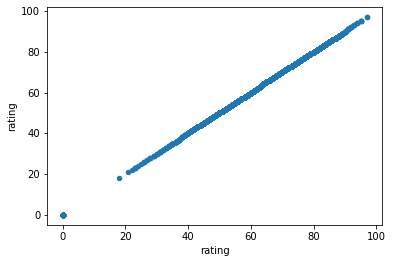

In [345]:
df[['rating']].plot(x='rating', y='rating', kind='scatter')

## Feature Engeneering

In [196]:
from sklearn.preprocessing import LabelEncoder, Normalizer, StandardScaler, OneHotEncoder

In [179]:
df1 = df.copy()

In [180]:
def count_list_df(df, column: str) -> list:
    return [len(x) for x in df[column].values]

def minutes_or_season(duration: pd.Series) -> list:
    return ['minutes' if x[1].lower() in ['min', 'mins'] else 'season' if x[1].lower() in ['season', 'seasons'] else None for x in duration.values]

def duration_(duration: pd.Series) -> list:
    return [x[0] for x in duration.values]

In [181]:
df1['directors'] = count_list_df(df1, 'director')
df1['cast_amount'] = count_list_df(df1, 'cast')
df1['listed_in_amount'] = count_list_df(df1, 'listed_in')
df1['countries'] = count_list_df(df1, 'country')
df1['duration_amount'] = duration_(df1.duration)
df1['diff_added_release'] = df1.date_added.dt.year - df1.release_year

In [182]:
for i, cast_list in df1.cast.items():
    df1.at[i, 'cast'] = [actor.lower().lstrip(' ') for actor in cast_list]

for i, country in df1.country.items():
    df1.at[i, 'country'] = [c.lower().lstrip(' ') for c in country]

for i, genre in df1.listed_in.items():
    df1.at[i, 'listed_in'] = [g.lower().lstrip(' ').replace("'", "") for g in genre]

In [165]:
all_movies_cast = []
for cast_list in df1.cast:
    for actor in cast_list:
        all_movies_cast.append(actor)

In [166]:
pd.Series(all_movies_cast).value_counts()[:10]

bam                 568
anupam kher          33
shah rukh khan       30
om puri              27
naseeruddin shah     27
akshay kumar         26
yuki kaji            26
takahiro sakurai     25
paresh rawal         25
amitabh bachchan     24
dtype: int64

In [167]:
all_countries = []
for countries_list in df1.country:
    for c in countries_list:
        if c == 'none':
            all_countries.append(None)
        else:
            all_countries.append(c)

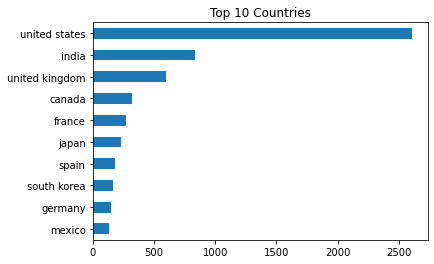

In [212]:
pd.Series(all_countries).value_counts()[:10].sort_values(ascending=True).plot(kind='barh', title='Top 10 Countries');
top_10_countries = pd.Series(all_countries).value_counts()[:10].index.tolist()

In [230]:
weights = (pd.Series(all_countries).value_counts()[:10]/pd.Series(all_countries).value_counts()[:10].max()).tolist()

In [233]:
weights.reverse()

In [234]:
weights

[0.04955820207452939,
 0.058009988474836724,
 0.0622358816749904,
 0.06838263542066846,
 0.08835958509412217,
 0.10411064156742221,
 0.12216673069535151,
 0.23088743757203228,
 0.3219362274298886,
 1.0]

In [213]:
# pd.Series(all_countries).value_counts()[:10].index

In [186]:
all_genre_list = []
for genre_list in df1.listed_in:
    for genre in genre_list:
        all_genre_list.append(genre)

# all_genre_list

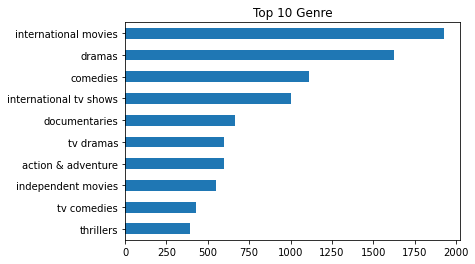

In [214]:
pd.Series(all_genre_list).value_counts()[:10].sort_values(ascending=True).plot(kind='barh', title='Top 10 Genre');
top_10_genre = pd.Series(all_genre_list).value_counts()[:10].index.tolist()

---

In [201]:
df2 = df1.copy()

In [197]:
label_encoder = LabelEncoder()

In [202]:
df2['type'] = label_encoder.fit_transform(df2.type)

In [223]:
top_10_countries.reverse()
top_10_countries

['mexico',
 'germany',
 'south korea',
 'spain',
 'japan',
 'france',
 'canada',
 'united kingdom',
 'india',
 'united states']

In [247]:
rank_list = []
for countries_list in df2.country:
    rank_scale = 0
    for country in countries_list:
        for w, c in zip(weights, top_10_countries):
            if country == c:
                rank_scale += w
    rank_list.append(rank_scale)

In [248]:
df2['country_rank'] = rank_list

In [262]:
df2.columns

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description',
       'directors', 'cast_amount', 'listed_in_amount', 'countries',
       'duration_amount', 'diff_added_release', 'country_rank',
       'date_added_month', 'date_added_year'],
      dtype='object')

In [269]:
df2['duration_amount'] = np.where(df2.type == 0, df2.duration_amount.values.astype(int) / 1000, df2.duration_amount.values.astype(int))

In [ ]:
bins = range(11)
labels = range(1, 11)
df2['bins'] = pd.cut(df2['rating']/10, bins=bins, labels=labels, include_lowest=True)

In [310]:
predictors = ['type', 'release_year', 'cast_amount', 'listed_in_amount',
              'countries', 'duration_amount', 'diff_added_release', 'country_rank',
              'date_added_month', 'date_added_year']
target = ['rating']
target_class = ['bins']
df2[predictors]

,type,release_year,cast_amount,listed_in_amount,countries,duration_amount,diff_added_release,country_rank,date_added_month,date_added_year
0,0,2019.0,10,2,4,0.090,0.0,1.384172,9,2019
1,0,2016.0,1,1,1,0.094,0.0,0.230887,9,2016
2,1,2013.0,12,1,1,1.000,5.0,1.000000,9,2018
3,1,2016.0,8,1,1,1.000,2.0,1.000000,9,2018
4,0,2017.0,12,1,1,0.099,0.0,1.000000,9,2017
...,...,...,...,...,...,...,...,...,...,...
6218,1,2017.0,5,2,3,2.000,2.0,0.000000,4,2019
6219,1,2019.0,7,2,1,2.000,0.0,0.088360,4,2019
6220,1,2012.0,3,1,1,2.000,4.0,0.122167,4,2016
6221,1,2016.0,7,2,1,2.000,0.0,0.088360,4,2016


## Model

In [320]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_score, recall_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

In [316]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [276]:
df3 = df2.copy()

In [312]:
X_train, X_test, y_train, y_test = train_test_split(
df3[predictors], df3[target_class], test_size=0.25, random_state=42)

In [313]:
regressor = DecisionTreeRegressor(random_state=0)
cross_val_score(regressor, X_train, y_train, cv=10)

array([-0.66617608, -0.53656675, -0.97760816, -0.57328426, -0.64414063,
       -0.53160204, -0.84528912, -0.53115009, -0.4800036 , -0.60547662])

In [324]:
models = [DecisionTreeRegressor(random_state=3),
                        AdaBoostRegressor(random_state=3, n_estimators=20),
                        GradientBoostingRegressor(random_state=3, n_estimators=1000),
                        RandomForestRegressor(random_state=3),
                        MLPRegressor(max_iter=5000, random_state=3),
                        LinearRegression()]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    # GaussianProcessClassifier(1.0 * RBF(1.0)),
    # DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

In [325]:
for model in classifiers:
    mod = model.fit(X_train, y_train)
    scores = cross_val_score(mod, X_train, y_train, cv=10)
    y_predict = mod.predict(X_test)
    # df3[type(mod).__name__] = scores
    print(type(mod).__name__, precision_score(y_test, y_predict, average='macro'), recall_score(y_test, y_predict, average='macro'), '\n')

KNeighborsClassifier 0.14489061078989499 0.1497082198255085 

SVC 0.21979155894741922 0.12848965979198024 

SVC 0.18388871664017598 0.12229552659440823 

RandomForestClassifier 0.22258159534127842 0.12708801896716107 

MLPClassifier 0.08716115875339887 0.1115587683639471 

AdaBoostClassifier 0.2861775899102305 0.16521031040063036 

GaussianNB 0.15961233979011843 0.17387098693845662 

QuadraticDiscriminantAnalysis 0.1634859716553858 0.16023535746897016 



In [326]:
df3

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,...,directors,cast_amount,listed_in_amount,countries,duration_amount,diff_added_release,country_rank,date_added_month,date_added_year,bins
0,81145628,0,Norm of the North: King Sized Adventure,"[Richard Finn, Tim Maltby]","[alan marriott, andrew toth, brian dobson, col...","[united states, india, south korea, china]",2019-09-09,2019.0,41.0,"[90, min]",...,2,10,2,4,0.090,0.0,1.384172,9,2019,5
1,80117401,0,Jandino: Whatever it Takes,[Unknow],[jandino asporaat],[united kingdom],2016-09-09,2016.0,52.0,"[94, min]",...,1,1,1,1,0.094,0.0,0.230887,9,2016,6
2,70234439,1,Transformers Prime,[Unknow],"[peter cullen, sumalee montano, frank welker, ...",[united states],2018-09-08,2013.0,82.0,"[1, Season]",...,1,12,1,1,1.000,5.0,1.000000,9,2018,9
3,80058654,1,Transformers: Robots in Disguise,[Unknow],"[will friedle, darren criss, constance zimmer,...",[united states],2018-09-08,2016.0,64.0,"[1, Season]",...,1,8,1,1,1.000,2.0,1.000000,9,2018,7
4,80125979,0,#realityhigh,[Fernando Lebrija],"[nesta cooper, kate walsh, john michael higgin...",[united states],2017-09-08,2017.0,57.0,"[99, min]",...,1,12,1,1,0.099,0.0,1.000000,9,2017,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6218,80162994,1,Talking Tom and Friends,[Unknow],"[colin hanks, tom kenny, james adomian, lisa s...","[cyprus, austria, thailand]",2019-04-10,2017.0,72.0,"[2, Seasons]",...,1,5,2,3,2.000,2.0,0.000000,4,2019,8
6219,80186475,1,Pokémon the Series,[Unknow],"[sarah natochenny, laurie hymes, jessica paque...",[japan],2019-04-01,2019.0,76.0,"[2, Seasons]",...,1,7,2,1,2.000,0.0,0.088360,4,2019,8
6220,70272742,1,Justin Time,[Unknow],"[gage munroe, scott mccord, jenna warren]",[canada],2016-04-01,2012.0,78.0,"[2, Seasons]",...,1,3,1,1,2.000,4.0,0.122167,4,2016,8
6221,80067942,1,Terrace House: Boys & Girls in the City,[Unknow],"[you, reina triendl, ryota yamasato, yoshimi t...",[japan],2016-04-01,2016.0,73.0,"[2, Seasons]",...,1,7,2,1,2.000,0.0,0.088360,4,2016,8


,rating,bins
0,41.0,5
1,52.0,6
2,82.0,9
3,64.0,7
4,57.0,6
...,...,...
6218,72.0,8
6219,76.0,8
6220,78.0,8
6221,73.0,8
